In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os

# Chargement de la base Sentiment140 préprocessée 

In [18]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if  NEGATION:
    file += "_neg"
df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))
df.head(10)

,sentiment,id,date,query_string,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww that is a bummer you shoulda got david ca...
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can not update his facebook b...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no it is not behaving at all i am mad why am i...
5,Negative,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not the whole crew
6,Negative,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need a hug
7,Negative,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains a bit only a bi...
8,Negative,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope they did not have it
9,Negative,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que me muera


In [19]:
df = df.sample(50000, random_state=1234)
df

,sentiment,id,date,query_string,user,text
599410,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
...,...,...,...,...,...,...
127568,Negative,1834743233,Mon May 18 04:03:19 PDT 2009,NO_QUERY,StineChantel,helgevakt ja
769726,Negative,2301549398,Tue Jun 23 15:35:26 PDT 2009,NO_QUERY,kristinedarlo,i want my henry roth
1027701,Positive,1932496118,Tue May 26 21:35:08 PDT 2009,NO_QUERY,Ptrsha,i will turn in now bye twitter
1372244,Positive,2051235071,Fri Jun 05 21:15:59 PDT 2009,NO_QUERY,suzechooch,throwin it old school you know you love it


In [20]:
X = df.text.to_list()
y = df.sentiment.to_list()

# Count Vectorizer
## Exemple

In [21]:
arr = ["Car was cleaned by Jack", "Jack was cleaned by Car", "Hello"]
vectorizer = CountVectorizer()
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['by', 'car', 'cleaned', 'hello', 'jack', 'was']

In [22]:
print(X_.toarray())

[[1 1 1 0 1 1]
 [1 1 1 0 1 1]
 [0 0 0 1 0 0]]


## Application

In [23]:
def conf_matrix(X, y, vectorizer, model, verbose=True):
    X = vectorizer.fit_transform(X).toarray()
    
    X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, train_size=0.80, random_state=1234)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
    sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
    sc_f1 = metrics.f1_score(y_pred, y_test, pos_label="Positive")
    sc_recall = metrics.recall_score(y_pred, y_test, pos_label="Positive")
    sc_precision = metrics.precision_score(y_pred, y_test, pos_label="Positive")
    sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    probs = model.predict_proba(X_test)[:,1]
    
    if verbose:    
        metrics.plot_confusion_matrix(model, X_test, y_test)
        plt.show()

        print(f"Accuracy : {sc_accuracy}")
        print(f"Balanced accuracy : {sc_balanced_accuracy}")
    #     print(f"Recall : {sc_recall}")
    #     print(f"Precision : {sc_precision}")
    #     print(f"F1 : {sc_f1}")
        print(f"ROC AUC : {sc_roc_auc}")
    
    metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}
    
    if not verbose:
        return X_train, X_test, y_train, y_test, probs, metrics_score
    

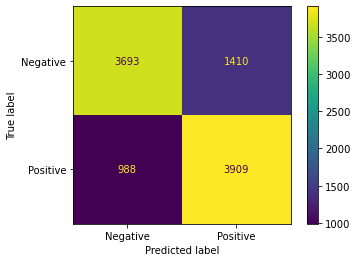

Accuracy : 0.7602
Balanced accuracy : 0.7619232830080874
ROC AUC : 0.8343160703676211


In [24]:
conf_matrix(X, y, CountVectorizer(max_features = 1000), LogisticRegression())

# TF-IDF
## Exemple

In [25]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = TfidfVectorizer()
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue', 'by', 'car', 'cleaned', 'hello', 'jack', 'red', 'was']

In [26]:
print(X_.toarray())

[[0.50689001 0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.         0.38550292]
 [0.         0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.50689001 0.38550292]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]]


## Application

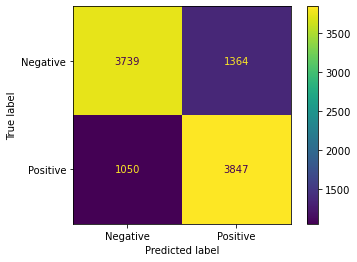

Accuracy : 0.7586
Balanced accuracy : 0.7594967822497015
ROC AUC : 0.8404903704936229


In [27]:
conf_matrix(X, y, TfidfVectorizer(max_features = 1000), LogisticRegression())

# N-grams
## Exemple

In [28]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = CountVectorizer(ngram_range=(2,2))
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue car',
 'by jack',
 'by red',
 'car was',
 'cleaned by',
 'jack was',
 'red car',
 'was cleaned']

In [29]:
print(X_.toarray())

[[1 1 0 1 1 0 0 1]
 [0 0 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 0]]


## Application

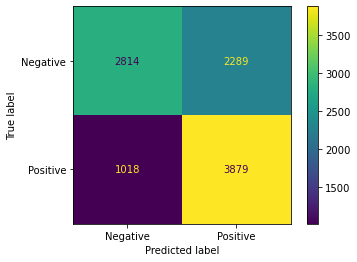

Accuracy : 0.6693
Balanced accuracy : 0.681616715270952
ROC AUC : 0.745171300893247


In [30]:
conf_matrix(X, y, CountVectorizer(max_features = 1000, ngram_range=(2,2)), LogisticRegression(max_iter=200))

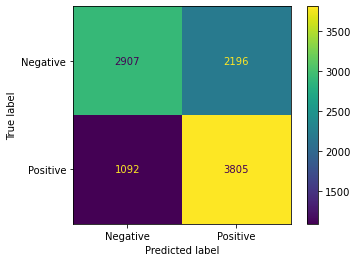

Accuracy : 0.6712
Balanced accuracy : 0.6804963613841304
ROC AUC : 0.7472049438899891


In [31]:
conf_matrix(X, y, TfidfVectorizer(max_features = 1000, ngram_range=(2,2)), LogisticRegression(max_iter=200))

# Comparaisons

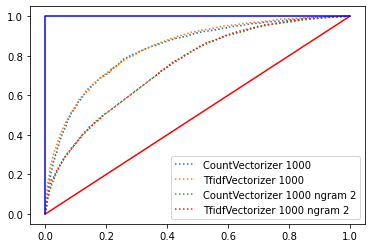

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.7602,0.761923,0.834316
TfidfVectorizer 1000,0.7586,0.759497,0.840490
CountVectorizer 1000 ngram 2,0.6693,0.681617,0.745171
TfidfVectorizer 1000 ngram 2,0.6712,0.680496,0.747205


In [32]:
table = []

N = 1000

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N}")
table.append(metrics_score)

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N}")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N} ngram 2")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N} ngram 2")
table.append(metrics_score)

plt.plot([0, 1], [0, 1], "r-")
plt.plot([0, 0, 1], [0, 1, 1], 'b-')

plt.legend()
plt.show()

pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"])

**Conclusion :** Le modèle de feature extraction le plus performant est le `TfidfVectorizer`. L'ajout de la fonction ngram demande en fait d'augmenter le nombre de features (de $n$ à $n^2$, ce qui demande plus de temps de calcul.

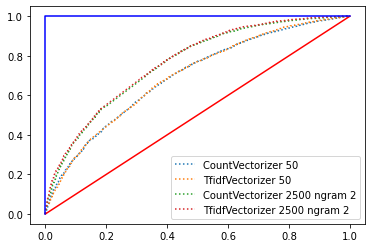

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 50,0.6399,0.644701,0.694696
TfidfVectorizer 50,0.6415,0.643489,0.695593
CountVectorizer 2500 ngram 2,0.6872,0.694909,0.761733
TfidfVectorizer 2500 ngram 2,0.6882,0.693659,0.767187


In [33]:
table = []

N = 50

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N}")
table.append(metrics_score)

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N}")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N**2, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N**2} ngram 2")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N**2, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N**2} ngram 2")
table.append(metrics_score)

plt.plot([0, 1], [0, 1], "r-")
plt.plot([0, 0, 1], [0, 1, 1], 'b-')

plt.legend()
plt.show()

pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N**2} ngram 2", f"TfidfVectorizer {N**2} ngram 2"])

# Influence du nombre de features

array([  100.        ,   166.81005372,   278.25594022,   464.15888336,
         774.26368268,  1291.54966501,  2154.43469003,  3593.8136638 ,
        5994.84250319, 10000.        ])

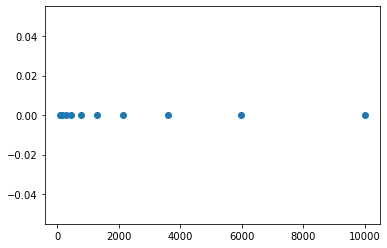

In [34]:
N = 10
plt.plot(np.logspace(2, 4, N, endpoint=True), np.zeros(N), 'o')
np.logspace(2, 4, N, endpoint=True)

In [35]:
%%time
N = 20
max_features_list = np.logspace(2, 3.8, N, endpoint=True, dtype=int)   # De 10^2 à 10^3.8
table = []
for max_features in max_features_list:
    _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = max_features), LogisticRegression(max_iter=200), verbose=False)
    table.append(metrics_score)
df = pd.DataFrame(table, index=max_features_list)

Wall time: 2min 44s


[]

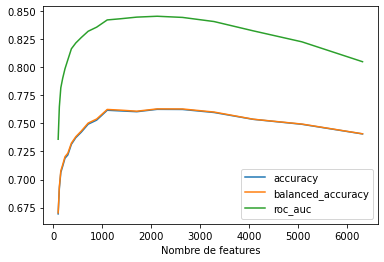

In [36]:
for i in df.columns:
    df[i].plot(label=i)

plt.legend()
plt.xlabel("Nombre de features")
plt.plot()